In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install 'datasets' 'contractions'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.9 MB/s eta 0:00:00


In [3]:
import contractions
import datasets

In [2]:
import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from urllib.parse import urljoin

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Input, RepeatVector, SimpleRNN, Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint

In [5]:
source_path = '/content/drive/MyDrive/NPL_AIO'

In [6]:
corpus = datasets.load_dataset('mt_eng_vietnamese', 'iwslt2015-en-vi')

Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Dataset mt_eng_vietnamese downloaded and prepared to /root/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
corpus

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 133318
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
})

In [8]:
def preprocess_text(text, en =False):
  if en:
    text =text.replace('&quot;', ' ')
    text = text.replace('&apos;', "'")
    text = contractions.fix(text)
  text = text.lower()
  punc_number = list(string.punctuation + string.digits)
  for c in punc_number:
    text = text.replace(c, ' ')
  return ' '.join(text.split())


In [9]:
preprocess_text("I'll... 2 35")

'i ll'

In [10]:
en_corpus = []
vi_corpus = []
for data in corpus['train']:
  en_corpus.append(preprocess_text('startseq ' + data['translation']['en'] + ' endseq', en = True))
  vi_corpus.append(preprocess_text('startseq ' + data['translation']['vi'] + ' endseq'))

In [11]:
vi_corpus[0], en_corpus[0]

('startseq khoa học đằng sau một tiêu đề về khí hậu endseq',
 'startseq rachel pike the science behind a climate headline endseq')

In [12]:
for t in vi_corpus:
  print(t.split())
  print(len(t.split()))
  break

['startseq', 'khoa', 'học', 'đằng', 'sau', 'một', 'tiêu', 'đề', 'về', 'khí', 'hậu', 'endseq']
12


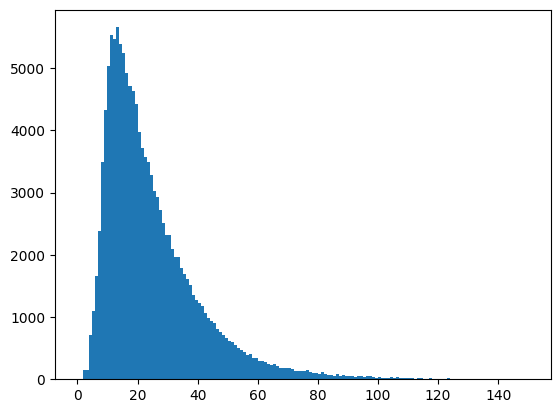

In [13]:
plt.hist([len(t.split())for t in vi_corpus], bins = 150, range = (0,150))
plt.show()

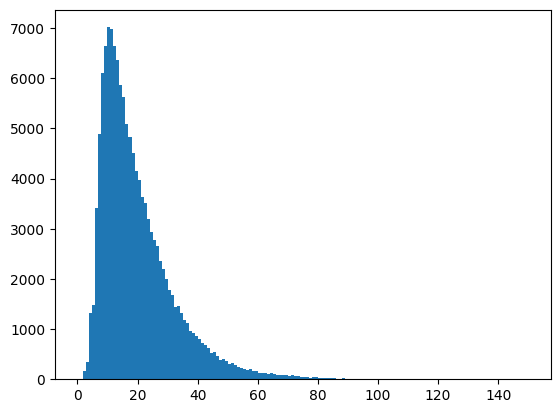

In [14]:
plt.hist([len(t.split())for t in en_corpus], bins = 150, range = (0,150))
plt.show()

In [15]:
vi_train, vi_test, en_train, en_test = train_test_split(vi_corpus, en_corpus, test_size = 0.3, random_state = 42)
vi_valid, vi_test, en_valid, en_test = train_test_split(vi_test, en_test, test_size = 0.5, random_state = 42)


In [16]:
len(vi_train), len(vi_valid), len(vi_test)

(93322, 19998, 19998)

In [17]:
vi_data, en_data, type_data = [],[],[]
for vi, en in zip(vi_train, en_train):
  vi_data.append(vi)
  en_data.append(en)
  type_data.append('train')

for vi, en in zip(vi_valid, en_valid):
  vi_data.append(vi)
  en_data.append(en)
  type_data.append('valid')

for vi, en in zip(vi_test, en_test):
  vi_data.append(vi)
  en_data.append(en)
  type_data.append('test')


In [18]:
df = pd.DataFrame()
df['vi'] = vi_data
df['en'] = en_data
df['type_data'] = type_data

In [19]:
df

,vi,en,type_data
0,startseq lúc đó ngồi cạnh tôi là một học sinh ...,startseq and in the seat next to me was a high...,train
1,startseq và tôi nghĩ theo thời gian những năm ...,startseq and i think with time in the years to...,train
2,startseq liệu có đúng không nếu đánh giá một n...,startseq isn t the measure of a man his willin...,train
3,startseq đèn đỏ giao thông có bảng đếm ngược e...,startseq red traffic lights have a countdown d...,train
4,startseq nhưng làm sao chúng làm được điều đó ...,startseq but how do we do that endseq,train
...,...,...,...
133313,startseq cho phép tôi tinh giảm điều này tới m...,startseq and let me reduce this to the simples...,test
133314,startseq các bạn đều biết twitter và các phiên...,startseq you know twitter and twitter clones h...,test
133315,startseq nguồn tài chính quan trọng không kém ...,startseq the supply of money — just as importa...,test
133316,startseq ở tuổi tôi đã tuyển những người từ đạ...,startseq at the age of i was recruiting people...,test


# save fix train/validation/test set

In [27]:
source_path = '/content/drive/MyDrive/NPL_AIO/save_model'

In [21]:
df.to_csv(urljoin(source_path, 'save_model/machine_translation_en_vi.csv'), index = False)

In [28]:
df = pd.read_csv(urljoin(source_path, 'save_model/machine_translation_en_vi.csv'))

In [29]:
df

,vi,en,type_data
0,startseq lúc đó ngồi cạnh tôi là một học sinh ...,startseq and in the seat next to me was a high...,train
1,startseq và tôi nghĩ theo thời gian những năm ...,startseq and i think with time in the years to...,train
2,startseq liệu có đúng không nếu đánh giá một n...,startseq isn t the measure of a man his willin...,train
3,startseq đèn đỏ giao thông có bảng đếm ngược e...,startseq red traffic lights have a countdown d...,train
4,startseq nhưng làm sao chúng làm được điều đó ...,startseq but how do we do that endseq,train
...,...,...,...
133313,startseq cho phép tôi tinh giảm điều này tới m...,startseq and let me reduce this to the simples...,test
133314,startseq các bạn đều biết twitter và các phiên...,startseq you know twitter and twitter clones h...,test
133315,startseq nguồn tài chính quan trọng không kém ...,startseq the supply of money — just as importa...,test
133316,startseq ở tuổi tôi đã tuyển những người từ đạ...,startseq at the age of i was recruiting people...,test


In [30]:
vi_train, en_train = df[df.type_data == 'train'].vi, df[df.type_data == 'train'].en
vi_valid, en_valid = df[df.type_data == 'valid'].vi, df[df.type_data == 'valid'].en
vi_test, en_test = df[df.type_data == 'test'].vi, df[df.type_data == 'test'].en

In [31]:
# feature extraction
vi_max_len = 100
en_max_len = 80

In [32]:
a = [5,6,8]
a[:-1]

[5, 6]

In [34]:
def encode_sequence(tokenizer, max_len, corpus, is_seq2seq = False):
  if not is_seq2seq:
    seqs = tokenizer.texts_to_sequences(corpus)
    padded_seqs = pad_sequences(seqs, maxlen = max_len, padding = 'post', truncating = 'post')
    return padded_seqs

  else:
    input_corpus = [" ".join(i.split()[: -1] for i in corpus)]
    input_seqs = tokenizer.texts_to_sequences(input_corpus)
    input_padded_seqs = pad_sequences(input_seqs, maxlen = max_len, padding = 'post', truncating = 'post')

    output_corpus = [" ".join(i.split()[1:]) for i in corpus]
    output_seqs = tokenizer.texts_to_sequences(output_corpus)
    output_padded_seqs = pad_sequences(output_seqs, maxlen = max_len, padding = "post", truncating = 'post')

    return input_padded_seqs, output_padded_seqs

def encode_outputs(seqs, vocab_size):
  padded_seqs = to_categorical(seqs, en_vocab_size)
  padded_seqs = np.array(padded_seqs)
  padded_seqs = padded_seqs.reshape(seqs.shape[0], seqs.shape[1], vocab_size)
  return padded_seqs

In [35]:
vi_tokenizer = Tokenizer(oov_token = '<OOV>')
vi_tokenizer.fit_on_texts(vi_train)
vi_word_dict = vi_tokenizer.word_index
vi_vocab_size = len(vi_word_dict) +1
vi_vocab_size


16055

In [36]:
vi_train_padded_seqs = encode_sequence(vi_tokenizer, vi_max_len, vi_train)
vi_valid_padded_seqs = encode_sequence(vi_tokenizer, vi_max_len, vi_valid)

vi_train_padded_seqs.shape, vi_valid_padded_seqs.shape

((93322, 100), (19998, 100))

In [37]:
len(vi_train_padded_seqs[0])


100

In [38]:
en_tokenizer = Tokenizer(oov_token = "<OOV>")
en_tokenizer.fit_on_texts(en_train)
en_word_dict = en_tokenizer.word_index
en_vocab_size = len(en_word_dict) + 1
en_vocab_size

36270

In [17]:
en_train_seqs = encode_sequence(en_tokenizer,en_max_len,en_train)
en_valid_seqs = encode_sequence(en_tokenizer,en_max_len,en_valid)

In [41]:
en_train_seqs.shape, en_valid_seqs.shape

((93322, 80), (19998, 80))

In [19]:
en_train_seqs[0]

array([   2,    5,   11,    4, 2352,  189,    6,   54,   22,    8,  261,
        204,  908,    8, 4456,    5,   97,  191,   42,    8,   74,  652,
        309,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [42]:
seqs = en_train_seqs
print(seqs.shape[0])
print(seqs.shape[1])

93322
80


In [ ]:
padded_seqs = to_categorical(seqs, en_vocab_size)
padded_seqs
padded_seqs = np.array(padded_seqs)
padded_seqs
#padded_seqs = padded_seqs.reshape(seqs.shape[0], seqs.shape[1], vocab_size)